In [1]:
# load packages
import os
import glob
import tensorflow as tf
from input_server import imgs_input_fn, build_model
import numpy as np
import pandas as pd
import math
from keras import models
from scipy.stats import norm
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from sklearn.metrics import mean_squared_error, mean_absolute_error
from helpers_trans import find_closest_element, get_beta_model
import matplotlib.pyplot as plt

In [2]:
# path of model checkpoints
checkpoint_path = '../../../data/models/20200926_nvidia/'
extracted_coefficients_directory = '../../../bdd100k_test_data/extracted_coefficients/10092020'
model_dir = '../../../data/models/20200924_nvidia_model/'
#val_path = '../../data/tfrecords/03082020/val_5000.tfrecords'
shard_path = '../../../data/tfrecords/shards/20200922'
#shard_files = glob.glob(os.path.join(shard_path, "*.tfrecords")) 
shard_files = ['../../../data/tfrecords/shards/20200925/train0_clean2.tfrecords',
              '../../../data/tfrecords/shards/20200925/train1_clean2.tfrecords',
              #'../../../data/tfrecords/shards/20200925/train2_clean2.tfrecords',
              # '../../../data/tfrecords/shards/20200925/train4_clean2.tfrecords',
              # '../../../data/tfrecords/shards/20200925/train5_clean2.tfrecords',
              # '../../../data/tfrecords/shards/20200925/train6_clean2.tfrecords'
              ]

In [3]:

# construct keras model
Input = tf.keras.layers.Input(shape=(66, 200, 3,), name='image')
x = Conv2D(24, kernel_size=(5, 5), activation='relu', strides=(2, 2))(Input)
x = BatchNormalization()(x)
x = Conv2D(36, kernel_size=(5, 5), activation='relu', strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(48, kernel_size=(5, 5), activation='relu', strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
#x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(1164)(x)
x = Dropout(0.5)(x)
x = Dense(100)(x)
x = Dense(50)(x)     
x = Dense(16)(x)
Output = Dense(1, name = 'output_layer')(x)
    
keras_model = tf.keras.models.Model(
  inputs = [Input], outputs = [Output])

# update model with weights
#keras_model.load_weights(tf.train.latest_checkpoint(checkpoint_path))

keras_model.compile(
    loss = 'mae',
    optimizer = keras.optimizers.Adadelta(learning_rate = 0.0005, rho = 0.95, epsilon = 1e-07, name = 'Adadelta'),
    metrics=['mse', 'mae'])

#beta_model = tf.keras.estimator.model_to_estimator(keras_model = keras_model) #, model_dir = model_dir


# to inspect weights:
#i = 0 
#for layer in keras_model.layers: 
#    i += 1
#    if i == 16:
#        print(layer.get_config(), layer.get_weights())

# get list of all variables in checkpoint file
# tf.train.list_variables(tf.train.latest_checkpoint(checkpoint_path))

In [4]:
layer_outputs = [layer.output for layer in keras_model.layers[:12]] 
activation_model = models.Model(inputs=keras_model.input, outputs=layer_outputs) 
activation_model.compile(
    loss = 'mse',
    optimizer=keras.optimizers.Adadelta(learning_rate=0.0005, rho=0.95, epsilon=1e-07, name='Adadelta'),
    metrics=['mse', 'mae'])
#activation_model_estimator = tf.keras.estimator.model_to_estimator(
#      keras_model=activation_model, model_dir = checkpoint_path)

In [ ]:
cust_train_input_fn_val = lambda: imgs_input_fn(shard_files)
pred_results_b_zeta_val = beta_model.predict(input_fn = cust_train_input_fn_val)

In [7]:
images = []
labels = []
X = []
y_true = []
for shards in shard_files:
    for i in range(0,1):
        image, label = imgs_input_fn(shards)
        images.append(image)
        labels.append(label)
        Xnew = np.array(images[0]['image'])
        ynew_true = np.array(labels[0])
        X.append(Xnew)
        y_true.append(ynew_true)

In [8]:
X = np.array(X).reshape(6000,66,200,3)

In [9]:
test_x = X[300,:,:,:].reshape(1,66,200,3)

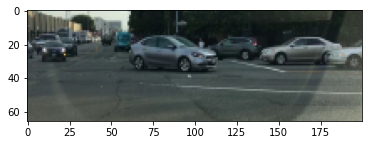

In [10]:
plt.imshow(test_x.reshape(66,200,3))

In [11]:
pred_cnn = activation_model.predict(test_x)

In [28]:
test = pred_cnn[1][:,:,:,11].reshape(31,98)

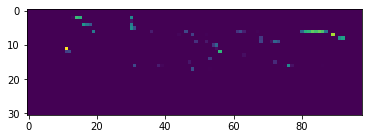

In [29]:
plt.imshow(test)

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df  = pd.read_csv('../../../data/tfrecords/val/20200925/yaws_only.csv', header = None)